# TACTIC Analyses
This notebook contains the code for all analyses conducted in the TACTIC manuscript.

In [1]:
# Restore point (runtime: ~1 minute)
import pickle
from urllib.request import urlopen
link = 'https://www.dropbox.com/scl/fi/38ewb000ihqcg6wev41g3/TACTIC_data_master.pkl?rlkey=zvxnt71ejj5ucexgpr1plmyvg&dl=1'
ecoli, mtb, master, out = pickle.load(urlopen(link))

## 0. Set Up Environment
Import dependencies and load datasets.


### 0.1 Import dependencies

In [2]:
# Import dependencies
import cv2
import math
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import sparse
from scipy.stats import spearmanr, ttest_ind, hypergeom, chi2_contingency
from sklearn.ensemble import RandomForestRegressor
from itertools import compress, combinations, chain
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt

# Import relevant function from INDIGOpy
from indigopy.core import featurize, classify

### 0.2 Load datasets

In [ ]:
# Load datasets
omics_data  = {
    'ecoli': pd.read_excel('./data/omics_data.xlsx', sheet_name='ecoli_chemogenomics', engine='openpyxl'), 
    'mtb': pd.read_excel('./data/omics_data.xlsx', sheet_name='mtb_transcriptomics', engine='openpyxl')
}
ixn_data    = pd.read_excel('./data/ixn_data.xlsx', sheet_name=None, engine='openpyxl')
orthology   = {
    'ecoli': pd.read_csv('./data/OrtholugeDB/Ec-MG1655_pathogens.txt', sep='\t'), 
    'mtb': pd.read_csv('./data/OrtholugeDB/Mtb-H37Rv_pathogens.txt', sep='\t')
}

# Define strain-specific orthology data
strains         = sorted(set(ixn_data['data']['Strain']))
strains         = strains + ['M. abscessus', 'M. smegmatis']
jx              = [1, 3] + [x for x in range(4, orthology['ecoli'].shape[1], 3)]
df1, df2        = orthology['ecoli'].iloc[:, jx], orthology['mtb'].iloc[:, jx]
df1.columns     = [s.split(' - ')[0] if 'comparison' in s else s for s in df1.columns]
df2.columns     = [s.split(' - ')[0] if 'comparison' in s else s for s in df2.columns]
df2.iloc[:, 0]  = [s.replace('RVBD_', 'Rv') for s in df2.iloc[:, 0]]
emap, mmap      = dict(), dict()
for strain in strains: 
    # E. coli strains
    if strain.endswith('iAi1'): 
        s1 = [s for s in df1.columns if s.endswith('IAI1')][0]
        s2 = [s for s in df2.columns if s.endswith('IAI1')][0]
    elif strain.startswith('E. coli'): 
        s1 = [s for s in df1.columns if 'MG1655' in s][0]
        s2 = [s for s in df2.columns if 'MG1655' in s][0]
    # M. tb strains
    elif 'tuberculosis' in strain: 
        s1 = [s for s in df1.columns if 'H37Rv' in s][0]
        s2 = [s for s in df2.columns if 'H37Rv' in s][0]
    # TACTIC strains
    elif 'aureus' in strain: 
        s1 = [s for s in df1.columns if 'aureus' in s][0]
        s2 = [s for s in df2.columns if 'aureus' in s][0]
    elif 'baumannii' in strain: 
        s1 = [s for s in df1.columns if 'baumannii' in s][0]
        s2 = [s for s in df2.columns if 'baumannii' in s][0]
    elif strain.endswith('PAO1'): 
        s1 = [s for s in df1.columns if s.endswith('PAO1')][0]
        s2 = [s for s in df2.columns if s.endswith('PAO1')][0]
    elif strain.endswith('PA14'): 
        s1 = [s for s in df1.columns if s.endswith('PA14')][0]
        s2 = [s for s in df2.columns if s.endswith('PA14')][0]
    elif strain.endswith('14028s'): 
        s1 = [s for s in df1.columns if s.endswith('14028S')][0]
        s2 = [s for s in df2.columns if s.endswith('14028S')][0]
    elif strain.endswith('LT2'): 
        s1 = [s for s in df1.columns if s.endswith('LT2')][0]
        s2 = [s for s in df2.columns if s.endswith('LT2')][0]
    # NTM strains
    elif 'abscessus' in strain: 
        s1 = [s for s in df1.columns if 'abscessus' in s][0]
        s2 = [s for s in df2.columns if 'abscessus' in s][0]
    elif 'smegmatis' in strain: 
        s1 = [s for s in df1.columns if 'smegmatis' in s][0]
        s2 = [s for s in df2.columns if 'smegmatis' in s][0]
    emap[strain] = list(compress(df1.iloc[:, 0], df1[s1] != '0'))
    mmap[strain] = list(compress(df2.iloc[:, 0], df2[s2] != '0'))

In [ ]:
# Checkpoint
with open('./TACTIC_data.pkl', 'wb') as f: 
    pickle.dump([ecoli, mtb, master, out], f)

## 1. Define Inputs and Outputs
Define main input (*ecoli*, *mtb*, *master*) and output (*out*) variables.

### 1.1 Instantiate variables (runtime: ~2 minutes)

In [ ]:
# I/O variables
ecoli, mtb, out = dict(), dict(), dict()

# Store orthology info
ecoli['map'], mtb['map'] = emap, mmap

# E. coli chemogenomic-based data
ecoli['key']    = list(zip(ixn_data['drug_key']['Code'], ixn_data['drug_key']['Chemogenomic_label']))
ecoli['key']    = [key for key in ecoli['key'] if not pd.isna(key[1])]
ecoli['omics']  = omics_data['ecoli']
profiles        = ecoli['omics'].iloc[:, 1:].to_dict('list')
feature_names   = ecoli['omics']['Gene'].tolist()
interactions    = [list(s.split(', ')) for s in ixn_data['data']['Interaction']]
feature_data    = featurize(interactions, profiles, feature_names=feature_names, key=ecoli['key'], 
                            strains=ixn_data['data']['Strain'].tolist(), orthology_map=ecoli['map'])
ecoli['idx']    = feature_data['idx']
ecoli['df']     = feature_data['feature_df']

# M. tb transcriptomic-based data
mtb['key']      = list(zip(ixn_data['drug_key']['Code'], ixn_data['drug_key']['Transcriptomic_label']))
mtb['omics']    = omics_data['mtb']
profiles        = mtb['omics'].iloc[:, 1:].to_dict('list')
feature_names   = mtb['omics']['Gene'].tolist()
interactions    = [list(s.split(', ')) for s in ixn_data['data']['Interaction']]
feature_data    = featurize(interactions, profiles, feature_names=feature_names, key=mtb['key'], 
                            strains=ixn_data['data']['Strain'].tolist(), orthology_map=mtb['map'])
mtb['idx']      = feature_data['idx']
mtb['df']       = feature_data['feature_df']

c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:351: UserWarning: Not all feature names are unique. Enforcing unique entries for output
  warn('Not all feature names are unique. Enforcing unique entries for output')
c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:406: UserWarning: Drug profile information missing for 413 interactions
  warn('Drug profile information missing for {} interactions'.format(len(interactions) - len(ixn_list)))
Mapping orthologous genes: 100%|██████████| 12/12 [00:33<00:00,  2.79s/it]


### 1.2 Define feature data

In [4]:
# Define master data
ecoli_genes     = [g for g in ecoli['omics']['Gene'].tolist() if g not in ecoli['map']['M. tuberculosis H37Rv']]
idx             = [any(i.split('_')[0].endswith(gene) for gene in ecoli_genes) for i in list(ecoli['df'].index)]
master          = {'data': ixn_data['data'], 'df': pd.concat([ecoli['df'].loc[idx], mtb['df']])}

# Define ML inputs
ecoli['X']      = sparse.csr_matrix(ecoli['df'].to_numpy().transpose())
mtb['X']        = sparse.csr_matrix(mtb['df'].to_numpy().transpose())
master['X']     = sparse.csr_matrix(master['df'].to_numpy().transpose())

# Define output data fields
out['strains']  = sorted(list(set(master['data']['Strain'])))
out['species']  = sorted(list(set([' '.join(s.split(' ')[0:2]) for s in master['data']['Strain'].tolist()])))
out['drugs']    = sorted(list(set(chain.from_iterable([list(combo.split(', ')) for combo in master['data']['Interaction']]))))
out['model']    = dict()

In [ ]:
# Checkpoint
with open('./TACTIC_data.pkl', 'wb') as f: 
    pickle.dump([ecoli, mtb, master, out], f)

## 2. TACTIC Benchmarking

TACTIC benchmarking against [INDIGO](https://doi.org/10.15252/msb.20156777) and [INDIGO-Mtb](https://doi.org/10.1128/mbio.02627-19) in predicting drug interaction outcomes for *A. baumannii*, *E. coli*, *P. aeruginosa*, *S.* Typhimurium, *S. aureus*, and *M. tuberculosis* (Mtb).  

- Used **holdout validation**: for each species-specific data subset, the data for a strain of interest is held out for testing  

### 2.1 I/O

In [12]:
# Define I/O variables
idx             = master['data']['Set'] == 'TACTIC'
data            = master['data'].loc[idx]
strains         = sorted(list(set(data['Strain'])))
X1, X2, X       = ecoli['X'][idx], mtb['X'][idx], master['X'][idx]
out['bench']    = dict()

### 2.2 Model training (runtime: ~1 minute)

In [13]:
# Define INDIGO (E. coli) model
idx1    = master['data']['Set'] == 'ecoli'
data1   = master['data'].loc[idx1]
X1tr    = ecoli['X'][idx1]
m1      = RandomForestRegressor()
m1.fit(X1tr, data1['Score'].tolist())
out['model']['EC'] = m1

# Define INDIGO-Mtb (M. tb) model
idx2    = master['data']['Set'] == 'mtb'
data2   = master['data'].loc[idx2]
X2tr    = mtb['X'][idx2]
m2      = RandomForestRegressor()
m2.fit(X2tr, data2['Score'].tolist())
out['model']['TB'] = m2

### 2.3 Model evaluation (runtime: ~3.5 hours)

In [14]:
# Determine predictions for INDIGO (E. coli) model
out['bench']['EC'] = out['model']['EC'].predict(X1)

# Determine predictions for INDIGO-Mtb (M. tb) model
out['bench']['TB'] = out['model']['TB'].predict(X2)

In [21]:
# Evaluate TACTIC vs. INDIGO
N = data.shape[0]
for strain in tqdm(strains, desc='Evaluating TACTIC vs. INDIGO:'): 
    # Test set (strain of interest)
    test_ix         = [s == strain for s in data['Strain'].tolist()]
    test_ixns       = list(compress(data['Interaction'], test_ix))
    test_scores     = list(compress(data['Score'], test_ix))
    Xte, n          = X[test_ix], test_ix.count(True)
    print('\tStrain: {}, N = {} ({}%)'.format(strain, n, round(100*n/N, 1)))
    # Train set for TACTIC model
    train_ix        = [not i for i in test_ix]
    if strain==data1['Strain'].unique()[0]: 
        extra_X     = master['X'][idx2]
        extra_s     = master['data']['Score'][idx2].tolist()
    elif strain==data2['Strain'].unique()[0]: 
        extra_X     = master['X'][idx1]
        extra_s     = master['data']['Score'][idx1].tolist()
    else: 
        extra_X     = master['X'][idx1 | idx2]
        extra_s     = master['data']['Score'][idx1 | idx2].tolist()
    Xtr             = sparse.vstack((extra_X, X[train_ix]))
    train_scores    = extra_s + list(compress(data['Score'], train_ix))
    # Instantiate results
    df = pd.DataFrame({'Ixn': test_ixns, 'Score': test_scores, 
                       'EC': list(compress(out['bench']['EC'], test_ix)), 
                       'TB': list(compress(out['bench']['TB'], test_ix))})
    # Run TACTIC
    model           = RandomForestRegressor()
    model.fit(Xtr, train_scores)
    df['TACTIC'] = model.predict(Xte)
    # Print results
    r, p = spearmanr(df['Score'], df['EC'])
    print('\t\tHoldout results (INDIGO):\tR = {}, p = {:.3g}'.format(round(r, 2), p))
    r, p = spearmanr(df['Score'], df['TB'])
    print('\t\tHoldout results (INDIGO-Mtb):\tR = {}, p = {:.3g}'.format(round(r, 2), p))
    r, p = spearmanr(df['Score'], df['TACTIC'])
    print('\t\tHoldout results (TACTIC):\tR = {}, p = {:.3g}'.format(round(r, 2), p))
    # Store results
    out['bench'][strain] = df

Evaluating TACTIC vs. INDIGO::   0%|          | 0/12 [00:00<?, ?it/s]

	Strain: A. baumannii ATCC 17978, N = 45 (1.8%)


Evaluating TACTIC vs. INDIGO::   8%|▊         | 1/12 [18:50<3:27:11, 1130.13s/it]

		Holdout results (INDIGO):	R = 0.28, p = 0.0611
		Holdout results (INDIGO-Mtb):	R = -0.01, p = 0.952
		Holdout results (TACTIC):	R = 0.56, p = 7.51e-05
	Strain: E. coli BW25113, N = 473 (18.4%)


Evaluating TACTIC vs. INDIGO::  17%|█▋        | 2/12 [34:45<2:51:13, 1027.40s/it]

		Holdout results (INDIGO):	R = 0.24, p = 1.53e-07
		Holdout results (INDIGO-Mtb):	R = -0.01, p = 0.88
		Holdout results (TACTIC):	R = 0.51, p = 5.19e-32
	Strain: E. coli MC4100, N = 98 (3.8%)


Evaluating TACTIC vs. INDIGO::  25%|██▌       | 3/12 [54:18<2:44:03, 1093.67s/it]

		Holdout results (INDIGO):	R = 0.28, p = 0.00508
		Holdout results (INDIGO-Mtb):	R = -0.03, p = 0.79
		Holdout results (TACTIC):	R = 0.28, p = 0.00449
	Strain: E. coli MG1655, N = 452 (17.6%)


Evaluating TACTIC vs. INDIGO::  33%|███▎      | 4/12 [1:08:11<2:12:07, 990.89s/it]

		Holdout results (INDIGO):	R = 0.26, p = 2.15e-08
		Holdout results (INDIGO-Mtb):	R = -0.09, p = 0.047
		Holdout results (TACTIC):	R = 0.38, p = 8.67e-17
	Strain: E. coli iAi1, N = 316 (12.3%)


Evaluating TACTIC vs. INDIGO::  42%|████▏     | 5/12 [1:25:37<1:57:56, 1010.93s/it]

		Holdout results (INDIGO):	R = 0.17, p = 0.00181
		Holdout results (INDIGO-Mtb):	R = 0.15, p = 0.00791
		Holdout results (TACTIC):	R = 0.63, p = 6.14e-36
	Strain: M. tuberculosis ATCC 35801, N = 154 (6.0%)


Evaluating TACTIC vs. INDIGO::  50%|█████     | 6/12 [1:44:10<1:44:33, 1045.63s/it]

		Holdout results (INDIGO):	R = 0.04, p = 0.662
		Holdout results (INDIGO-Mtb):	R = 0.35, p = 9.88e-06
		Holdout results (TACTIC):	R = 0.16, p = 0.0519
	Strain: M. tuberculosis H37Rv, N = 159 (6.2%)


Evaluating TACTIC vs. INDIGO::  58%|█████▊    | 7/12 [2:00:39<1:25:34, 1026.98s/it]

		Holdout results (INDIGO):	R = 0.25, p = 0.00155
		Holdout results (INDIGO-Mtb):	R = 0.3, p = 9.27e-05
		Holdout results (TACTIC):	R = 0.17, p = 0.0275
	Strain: P. aeruginosa PA14, N = 163 (6.4%)


Evaluating TACTIC vs. INDIGO::  67%|██████▋   | 8/12 [2:18:58<1:09:59, 1049.98s/it]

		Holdout results (INDIGO):	R = 0.06, p = 0.421
		Holdout results (INDIGO-Mtb):	R = 0.17, p = 0.0342
		Holdout results (TACTIC):	R = 0.52, p = 1.82e-12
	Strain: P. aeruginosa PAO1, N = 163 (6.4%)


Evaluating TACTIC vs. INDIGO::  75%|███████▌  | 9/12 [2:37:39<53:36, 1072.07s/it]  

		Holdout results (INDIGO):	R = -0.13, p = 0.111
		Holdout results (INDIGO-Mtb):	R = -0.07, p = 0.358
		Holdout results (TACTIC):	R = 0.41, p = 8.01e-08
	Strain: S. aureus ATCC 29213, N = 45 (1.8%)


Evaluating TACTIC vs. INDIGO::  83%|████████▎ | 10/12 [2:57:01<36:39, 1099.79s/it]

		Holdout results (INDIGO):	R = 0.23, p = 0.135
		Holdout results (INDIGO-Mtb):	R = 0.16, p = 0.294
		Holdout results (TACTIC):	R = 0.2, p = 0.188
	Strain: S. typhimurium 14028s, N = 248 (9.7%)


Evaluating TACTIC vs. INDIGO::  92%|█████████▏| 11/12 [3:14:42<18:08, 1088.01s/it]

		Holdout results (INDIGO):	R = 0.05, p = 0.398
		Holdout results (INDIGO-Mtb):	R = 0.0, p = 0.987
		Holdout results (TACTIC):	R = 0.63, p = 4.03e-29
	Strain: S. typhimurium LT2, N = 248 (9.7%)


Evaluating TACTIC vs. INDIGO:: 100%|██████████| 12/12 [3:32:19<00:00, 1061.60s/it]

		Holdout results (INDIGO):	R = 0.08, p = 0.189
		Holdout results (INDIGO-Mtb):	R = 0.07, p = 0.307
		Holdout results (TACTIC):	R = 0.67, p = 1.07e-33


### 2.4 Model comparison (~15 minutes)

In [23]:
# Check other ML algorithms
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Loop through ML algorithms
MLcomp = dict()
algs = [LinearRegression(), Ridge(), SVR(), DecisionTreeRegressor(), GradientBoostingRegressor()]
for alg in tqdm(algs, desc='Evaluating alternative ML algorithms'): 
    # Define ML label
    label = str(alg)[:-2]
    MLcomp[label] = dict()
    # INDIGO
    m1 = alg.fit(X1tr, data1['Score'].tolist())
    MLcomp[label]['EC'] = m1.predict(X1)
    # INDIGO-Mtb
    m2 = alg.fit(X2tr, data2['Score'].tolist())
    MLcomp[label]['TB'] = m2.predict(X2)
    # TACTIC
    MLcomp[label]['TACTIC'] = np.empty(data.shape[0], dtype=float)
    for strain in tqdm(strains, desc='Building TACTIC models', leave=False): 
        # Test set (strain of interest)
        test_ix         = [s == strain for s in data['Strain'].tolist()]
        test_ixns       = list(compress(data['Interaction'], test_ix))
        test_scores     = list(compress(data['Score'], test_ix))
        Xte, n          = X[test_ix], test_ix.count(True)
        print('\tStrain: {}, N = {} ({}%)'.format(strain, n, round(100*n/N, 1)))
        # Train set for TACTIC model
        train_ix        = [not i for i in test_ix]
        if strain==data1['Strain'].unique()[0]: 
            extra_X     = master['X'][idx2]
            extra_s     = master['data']['Score'][idx2].tolist()
        elif strain==data2['Strain'].unique()[0]: 
            extra_X     = master['X'][idx1]
            extra_s     = master['data']['Score'][idx1].tolist()
        else: 
            extra_X     = master['X'][idx1 | idx2]
            extra_s     = master['data']['Score'][idx1 | idx2].tolist()
        Xtr             = sparse.vstack((extra_X, X[train_ix]))
        train_scores    = extra_s + list(compress(data['Score'], train_ix))
        # Instantiate results
        df = pd.DataFrame({'Ixn': test_ixns, 'Score': test_scores, 
                            'EC': list(compress(MLcomp[label]['EC'], test_ix)), 
                            'TB': list(compress(MLcomp[label]['TB'], test_ix))})
        # Run TACTIC
        model            = alg.fit(Xtr, train_scores)
        df['TACTIC']     = model.predict(Xte)
        # Store results
        MLcomp[label][strain] = df
        MLcomp[label]['TACTIC'][test_ix] = df['TACTIC']

# Save output
out['bench']['ML'] = MLcomp

Evaluating alternative ML algorithms:   0%|          | 0/5 [00:00<?, ?it/s]

	Strain: A. baumannii ATCC 17978, N = 45 (1.8%)


	Strain: E. coli BW25113, N = 473 (18.4%)


	Strain: E. coli MC4100, N = 98 (3.8%)


	Strain: E. coli MG1655, N = 452 (17.6%)


	Strain: E. coli iAi1, N = 316 (12.3%)


	Strain: M. tuberculosis ATCC 35801, N = 154 (6.0%)


	Strain: M. tuberculosis H37Rv, N = 159 (6.2%)


	Strain: P. aeruginosa PA14, N = 163 (6.4%)


	Strain: P. aeruginosa PAO1, N = 163 (6.4%)


	Strain: S. aureus ATCC 29213, N = 45 (1.8%)


	Strain: S. typhimurium 14028s, N = 248 (9.7%)


	Strain: S. typhimurium LT2, N = 248 (9.7%)


Evaluating alternative ML algorithms:  20%|██        | 1/5 [03:20<13:20, 200.19s/it]

	Strain: A. baumannii ATCC 17978, N = 45 (1.8%)


	Strain: E. coli BW25113, N = 473 (18.4%)


	Strain: E. coli MC4100, N = 98 (3.8%)


	Strain: E. coli MG1655, N = 452 (17.6%)


	Strain: E. coli iAi1, N = 316 (12.3%)


	Strain: M. tuberculosis ATCC 35801, N = 154 (6.0%)


	Strain: M. tuberculosis H37Rv, N = 159 (6.2%)


	Strain: P. aeruginosa PA14, N = 163 (6.4%)


	Strain: P. aeruginosa PAO1, N = 163 (6.4%)


	Strain: S. aureus ATCC 29213, N = 45 (1.8%)


	Strain: S. typhimurium 14028s, N = 248 (9.7%)


	Strain: S. typhimurium LT2, N = 248 (9.7%)


Evaluating alternative ML algorithms:  40%|████      | 2/5 [04:29<06:09, 123.19s/it]

	Strain: A. baumannii ATCC 17978, N = 45 (1.8%)


	Strain: E. coli BW25113, N = 473 (18.4%)


	Strain: E. coli MC4100, N = 98 (3.8%)


	Strain: E. coli MG1655, N = 452 (17.6%)


	Strain: E. coli iAi1, N = 316 (12.3%)


	Strain: M. tuberculosis ATCC 35801, N = 154 (6.0%)


	Strain: M. tuberculosis H37Rv, N = 159 (6.2%)


	Strain: P. aeruginosa PA14, N = 163 (6.4%)


	Strain: P. aeruginosa PAO1, N = 163 (6.4%)


	Strain: S. aureus ATCC 29213, N = 45 (1.8%)


	Strain: S. typhimurium 14028s, N = 248 (9.7%)


	Strain: S. typhimurium LT2, N = 248 (9.7%)


Evaluating alternative ML algorithms:  60%|██████    | 3/5 [10:28<07:41, 230.75s/it]

	Strain: A. baumannii ATCC 17978, N = 45 (1.8%)


	Strain: E. coli BW25113, N = 473 (18.4%)


	Strain: E. coli MC4100, N = 98 (3.8%)


	Strain: E. coli MG1655, N = 452 (17.6%)


	Strain: E. coli iAi1, N = 316 (12.3%)


	Strain: M. tuberculosis ATCC 35801, N = 154 (6.0%)


	Strain: M. tuberculosis H37Rv, N = 159 (6.2%)


	Strain: P. aeruginosa PA14, N = 163 (6.4%)


	Strain: P. aeruginosa PAO1, N = 163 (6.4%)


	Strain: S. aureus ATCC 29213, N = 45 (1.8%)


	Strain: S. typhimurium 14028s, N = 248 (9.7%)


	Strain: S. typhimurium LT2, N = 248 (9.7%)


Evaluating alternative ML algorithms:  80%|████████  | 4/5 [12:55<03:17, 197.96s/it]

	Strain: A. baumannii ATCC 17978, N = 45 (1.8%)


	Strain: E. coli BW25113, N = 473 (18.4%)


	Strain: E. coli MC4100, N = 98 (3.8%)


	Strain: E. coli MG1655, N = 452 (17.6%)


	Strain: E. coli iAi1, N = 316 (12.3%)


	Strain: M. tuberculosis ATCC 35801, N = 154 (6.0%)


	Strain: M. tuberculosis H37Rv, N = 159 (6.2%)


	Strain: P. aeruginosa PA14, N = 163 (6.4%)


	Strain: P. aeruginosa PAO1, N = 163 (6.4%)


	Strain: S. aureus ATCC 29213, N = 45 (1.8%)


	Strain: S. typhimurium 14028s, N = 248 (9.7%)


	Strain: S. typhimurium LT2, N = 248 (9.7%)


Evaluating alternative ML algorithms: 100%|██████████| 5/5 [18:01<00:00, 216.38s/it]


In [24]:
# Checkpoint
with open('./TACTIC_data.pkl', 'wb') as f: 
    pickle.dump([ecoli, mtb, master, out], f)

## 3. Model Interpretation

Inspection of feature importance and evaluation of pathways enriched by top features.

In [25]:
# Define full TACTIC model (runtime: ~20 minutes)
model = RandomForestRegressor()
model.fit(master['X'], master['data']['Score'].tolist())
out['model']['TACTIC'] = model

### 3.1 Extract top important features

In [26]:
# Import ecoli-to-mtb gene map
gmap = pd.read_csv('./data/OrtholugeDB/Ec-MG1655_Mtb-H37Rv.txt', sep='\t')
gmap = gmap[['Locus Tag (Strain 1)', 'Locus Tag (Strain 2)']].rename(
	columns={'Locus Tag (Strain 1)': 'ecoli', 'Locus Tag (Strain 2)': 'mtb'}
)
gmap['mtb'] = [g.replace('RVBD_', 'Rv') for g in gmap['mtb'].tolist()]

# Feature importance
mdl = out['model']['TACTIC']
fns = master['df'].index
gns = [s.split('-')[-1] for s in fns]
gns = [s.replace('RVBD_', 'Rv') for s in gns]
gns = [s.split('_')[0] for s in gns]
imp = mdl.feature_importances_
std = np.std([tree.feature_importances_ for tree in mdl.estimators_], axis=0)
df  = pd.DataFrame({'Gene': gns, 'Score': imp, 'SD': std}, index=fns)

# Calculate cumulative sum of importance scores
df  = df.sort_values(by=['Score'], ascending=False)
df['CS'] = np.cumsum(df['Score']) / np.sum(df['Score'])

# Rename gene column
idx = [g in df['Gene'].tolist() for g in gmap['mtb'].tolist()]
oegenes = list(compress(gmap['ecoli'].tolist(), idx))
omgenes = list(compress(gmap['mtb'].tolist(), idx))
labels = ['{} / {}'.format(eg, mg) for eg, mg in zip(oegenes, omgenes)]
df['Gene'] = df['Gene'].replace(dict(zip(omgenes, labels)))

# Save main output
out['importance'] = df

# Extract features that explain 95% 
k = np.argmax(df['CS'] > 0.95) + 1
genes = sorted(set(df['Gene'][:k]), key=lambda v: v.upper())

# Separate overlapping vs. unique genes
ogenes = [g for g in genes if '/' in g]
ugenes = [g for g in genes if g not in ogenes]

# Curate gene list for E. coli
egenes = sorted(set([g for g in ugenes if g.startswith('b')] + [g.split(' / ')[0] for g in ogenes]))
df = pd.read_csv('./data/OrtholugeDB/Ec-MG1655_all.txt', sep='\t')
df = df.iloc[:, 1:4]
df.columns = ['Locus', 'RefSeq', 'Description']
edf = df[df['Locus'].isin(egenes)]

# Curate gene list for M. tb
mgenes = sorted(set([g for g in ugenes if g.startswith('Rv')] + [g.split(' / ')[1] for g in ogenes]))
df = pd.read_csv('./data/OrtholugeDB/Mtb-H37Rv_all.txt', sep='\t')
df = df.iloc[:, 1:4]
df.columns = ['Locus', 'RefSeq', 'Description']
df['Locus'] = [s.replace('RVBD_', 'Rv') for s in df['Locus'].tolist()]
mdf = df[df['Locus'].isin(mgenes)]

### 3.2 GSEA based on KEGG database

In [27]:
# Instantialize output variable
out['gsea'] = dict()

#### 3.2.1 E. coli

In [28]:
# Import gene info
df = pd.read_csv('https://rest.kegg.jp/list/eco', sep='\t', header=None)
df.index = [s.split(':')[1] for s in df.iloc[:, 0].tolist()]
df['Gene'] = [s.split(';')[0] for s in df.iloc[:, -1]]
df['Description'] = [s.split('; ')[1] for s in df.iloc[:, -2]]
eco_genes = df[['Gene', 'Description']]

# Import pathway info
df = pd.read_csv('https://rest.kegg.jp/list/pathway/eco', sep='\t', header=None)
df = df.set_index(0).sort_index().rename(columns={1: 'Pathway'})
df['Pathway'] = [p.split(' - ')[0] for p in df['Pathway'].tolist()]
eco_path = df[['Pathway']]

# Import pathways + associated genes
df = pd.read_csv('https://rest.kegg.jp/link/eco/pathway', sep='\t', header=None)
df['pathway'] = [s.split(':')[1] for s in df.iloc[:, 0]]
df['gene'] = [s.split(':')[1] for s in df.iloc[:, 1]]
pathways = sorted(set(df['pathway'].values))
genes = sorted(set(df['gene'].values))
eco = dict()
for path in pathways: 
    eco[path] = df.loc[df['pathway']==path, 'gene'].tolist()
eco_path['N'] = [len(eco[path]) for path in eco_path.index]

# Add pathway to gene info
gene_dict = dict()
for g in genes: 
    pids = df['pathway'].values[df['gene']==g]
    pathway = [eco_path.loc[p, 'Pathway'] for p in pids]
    if len(pathway) > 1: 
        gene_dict[g] = ', '.join(pathway)
    else: 
        gene_dict[g] = pathway[0]
eco_genes['Pathway'] = eco_genes.index.map(gene_dict)

# Load gene list
with open('data/GSEA/ecoli_genes.txt') as file:
    egenes = [line.rstrip() for line in file]
eco_path['R'] = np.nan
for idx in eco_path.index: 
    eco_path.loc[idx, 'R'] = [g in eco[idx] for g in egenes].count(True)

# Hypergeometric test
M = len(genes)
N = [g in genes for g in egenes].count(True)
eco_path = eco_path.assign(p=lambda x: (hypergeom(M=M, n=x['N'], N=N).sf(x['R']-1)))
eco_path['padj'] = multipletests(eco_path['p'], method='fdr_bh')[1]
out['gsea']['ecoli'] = eco_path

#### 3.2.2 M. tb

In [29]:
# Import gene info
df = pd.read_csv('https://rest.kegg.jp/list/mtu', sep='\t', header=None)
df.index = [s.split(':')[1] for s in df.iloc[:, 0].tolist()]
df['Gene'] = [s.split(';')[0] for s in df.iloc[:, -1]]
def dscr(s): 
    try: 
        return s.split('; ')[1]
    except: 
        return s
df['Description'] = [dscr(s) for s in df.iloc[:, -2]]
mtu_genes = df[['Gene', 'Description']]

# Import pathway info
df = pd.read_csv('https://rest.kegg.jp/list/pathway/mtu', sep='\t', header=None)
df = df.set_index(0).sort_index().rename(columns={1: 'Pathway'})
df['Pathway'] = [p.split(' - ')[0] for p in df['Pathway'].tolist()]
mtu_path = df[['Pathway']]

# Import pathways + associated genes
df = pd.read_csv('https://rest.kegg.jp/link/mtu/pathway', sep='\t', header=None)
df['pathway'] = [s.split(':')[1] for s in df.iloc[:, 0]]
df['gene'] = [s.split(':')[1] for s in df.iloc[:, 1]]
pathways = sorted(set(df['pathway'].values))
genes = sorted(set(df['gene'].values))
mtu = dict()
for path in pathways: 
    mtu[path] = df.loc[df['pathway']==path, 'gene'].tolist()
mtu_path['N'] = [len(mtu[path]) for path in mtu_path.index]

# Add pathway to gene info
gene_dict = dict()
for g in genes: 
    pids = df['pathway'].values[df['gene']==g]
    pathway = [mtu_path.loc[p, 'Pathway'] for p in pids]
    if len(pathway) > 1: 
        gene_dict[g] = ', '.join(pathway)
    else: 
        gene_dict[g] = pathway[0]
mtu_genes['Pathway'] = mtu_genes.index.map(gene_dict)

# Load gene list
with open('data/GSEA/mtb_genes.txt') as file:
    mgenes = [line.rstrip() for line in file]
mtu_path['R'] = np.nan
for idx in mtu_path.index: 
    mtu_path.loc[idx, 'R'] = [g in mtu[idx] for g in mgenes].count(True)

# Hypergeometric test
M = len(genes)
N = [g in genes for g in mgenes].count(True)
mtu_path = mtu_path.assign(p=lambda x: (hypergeom(M=M, n=x['N'], N=N).sf(x['R']-1)))
mtu_path['padj'] = multipletests(mtu_path['p'], method='fdr_bh')[1]
out['gsea']['mtb'] = mtu_path

#### 3.2.3 Evaluate top predictors in enriched pathways

In [30]:
# Define genes
edf = out['gsea']['ecoli'][out['gsea']['ecoli']['padj'] < 0.05]
mdf = out['gsea']['mtb'][out['gsea']['mtb']['padj'] < 0.05]
genes = []
for i in edf.index: 
    genes = genes + eco[i]
for i in mdf.index: 
    genes = genes + mtu[i]

# Isolate input data
df = out['importance'][out['importance']['CS'] <= 0.95]
x = [f for f in df.index if any(g in f for g in genes)]
fdf = master['df'].loc[x]

# Conduct statistical test
t, p = [], []
sjx = master['data']['Label'] == 'Synergy'
ajx = master['data']['Label'] == 'Antagonism'
for i in fdf.index: 
    if i.startswith('sigma'): 
        x = fdf.loc[i].values[sjx]
        y = fdf.loc[i].values[ajx]
        tstat, pval = ttest_ind(a=x, b=y, equal_var=True)
        """
        if np.var(x)/np.var(y) > 4 or np.var(y)/np.var(x) > 4: 
            tstat, pval = ttest_ind(a=x, b=y, equal_var=False)
        else: 
            tstat, pval = ttest_ind(a=x, b=y, equal_var=True)
        """
    elif i.startswith('delta'): 
        cdf = pd.crosstab(master['data']['Label'][sjx | ajx], fdf.loc[i].values[sjx | ajx])
        tstat, pval, _, _ = chi2_contingency(cdf, correction=True)
    # Save results
    t.append(tstat)
    p.append(pval)
tdf = pd.DataFrame({'t': t, 'p': p}, index=fdf.index)
tdf['padj'] = multipletests(tdf['p'], method='fdr_bh')[1]

# Save results
out['gsea']['features'] = tdf

In [35]:
# Checkpoint
with open('./TACTIC_data.pkl', 'wb') as f: 
    pickle.dump([ecoli, mtb, master, out], f)

## 4. Prediction Landscape

Prediction of all possible 2-way interactions between 86 drugs across 18 bacterial strains and 9 media conditions.

### 4.1 Define input

In [36]:
# Instantiate output variable
out['landscape'] = dict()

# Determine all possible 2-way interactions
drugs           = [d for d in out['drugs'] if d not in ['GLUCOSE', 'GLYCEROL']]
interactions    = []
for k in range(2, 3):
    interactions.extend(combinations(drugs, k))
interactions    = [list(i) for i in interactions]

# Add media-specific interactions
media           = ['GLUCOSE', 'GLYCEROL', 'ACETATE', 'GLUCOSAMINE', 'MALTOSE', 'SUCCINATE', 'N-ACETYLGLUCOSAMINE', 'NH4CL']
ixn_media       = []
for m in media: 
    ixn_media   = ixn_media + [list(i) + [m] for i in interactions]

# Define TACTIC strains
tactic_strains  = sorted(out['strains'])

# Define NTM strains
ntm_strains     = ['M. abscessus', 'M. smegmatis']

# Define gut microbiome strains
orth            = {'ecoli': pd.read_csv('./data/OrtholugeDB/Ec-MG1655_gut.txt', sep='\t'), 
                    'mtb': pd.read_csv('./data/OrtholugeDB/Mtb-H37Rv_gut.txt', sep='\t')}
jx              = [1, 3] + [x for x in range(4, orth['ecoli'].shape[1], 3)]
df1, df2        = orth['ecoli'].iloc[:, jx], orth['mtb'].iloc[:, jx]
df1.columns     = [s.split(' - ')[0] if 'comparison' in s else s for s in df1.columns]
df2.columns     = [s.split(' - ')[0] if 'comparison' in s else s for s in df2.columns]
gut_strains     = sorted(df1.columns[2:])
emap, mmap      = dict(), dict()
for strain in gut_strains: 
    emap[strain] = list(compress(df1.iloc[:, 0], df1[strain] != '0'))
    mmap[strain] = list(compress(df2.iloc[:, 0], df2[strain] != '0'))

# Define strains list + ML inputs
strains         = tactic_strains + ntm_strains + gut_strains
all_ixns        = interactions + ixn_media
n1, n2, n       = len(all_ixns), len(strains), 50000
ixn_list        = n2 * all_ixns
str_list        = sorted(n1 * strains)

### 4.2 Determine predictions (runtime: ~4 hours)

In [37]:
# Define phenotype data + feature names + orthology maps
p1, p2  = ecoli['omics'].iloc[:, 1:].to_dict('list'), mtb['omics'].iloc[:, 1:].to_dict('list')
g1, g2  = ecoli['omics']['Gene'].tolist(), mtb['omics']['Gene'].tolist()
ecoli['map'].update(emap)
mtb['map'].update(mmap)

# Generate predictions (separate into batches)
print('Request size: {} predictions. Partitioning into {} batches...'.format(n1 * n2, math.ceil(n1 * n2 / n)))
start, stop, i, pred = 0, n, 1, []
while start < n1 * n2: 
    # Print batch number
    print('\tProcessing batch {}...'.format(i))
    # Define partitions
    if stop > n1 * n2: 
        i_list, s_list = ixn_list[start:], str_list[start:]
    else: 
        i_list, s_list = ixn_list[start:stop], str_list[start:stop]
    # Determine features
    f1      = featurize(i_list, p1, feature_names=g1, key=ecoli['key'], strains=s_list, orthology_map=ecoli['map'])
    f2      = featurize(i_list, p2, feature_names=g2, key=mtb['key'], strains=s_list, orthology_map=mtb['map'])
    d1, d2  = f1['feature_df'].to_numpy().transpose(), f2['feature_df'].to_numpy().transpose()
    # Re-format input data
    x1      = np.zeros([d2.shape[0], d1.shape[1]], dtype=d2.dtype)
    x1[np.array(f1['idx'])] = d1[np.array(f1['idx'])]
    idx1    = [f in master['df'].index for f in list(f1['feature_df'].index)]
    idx2    = [f in master['df'].index for f in list(f2['feature_df'].index)]
    s1, s2  = sparse.csr_matrix(x1[:, np.array(idx1)]), sparse.csr_matrix(d2[:, np.array(idx2)])
    X       = sparse.hstack((s1, s2))
    # Determine predictions
    pred.append(out['model']['TACTIC'].predict(X))
    # Re-define batch indices
    start   = stop
    stop    = start + n
    i       += 1
print('All predictions determined.')

Request size: 592110 predictions. Partitioning into 12 batches...
	Processing batch 1...


c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:351: UserWarning: Not all feature names are unique. Enforcing unique entries for output
  warn('Not all feature names are unique. Enforcing unique entries for output')
c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:406: UserWarning: Drug profile information missing for 24876 interactions
  warn('Drug profile information missing for {} interactions'.format(len(interactions) - len(ixn_list)))
Mapping orthologous genes: 100%|██████████| 2/2 [00:24<00:00, 12.37s/it]
c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:406: UserWarning: Drug profile information missing for 3655 interactions
  warn('Drug profile information missing for {} interactions'.format(len(interactions) - len(ixn_list)))
Mapping orthologous genes: 100%|██████████| 2/2 [00:24<00:00, 12.37s/it]


	Processing batch 2...


c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:351: UserWarning: Not all feature names are unique. Enforcing unique entries for output
  warn('Not all feature names are unique. Enforcing unique entries for output')
c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:406: UserWarning: Drug profile information missing for 24915 interactions
  warn('Drug profile information missing for {} interactions'.format(len(interactions) - len(ixn_list)))
Mapping orthologous genes: 100%|██████████| 3/3 [00:36<00:00, 12.22s/it]
c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:406: UserWarning: Drug profile information missing for 7310 interactions
  warn('Drug profile information missing for {} interactions'.format(len(interactions) - len(ixn_list)))
Mapping orthologous genes: 100%|██████████| 3/3 [00:28<00:00,  9.62s/it]


	Processing batch 3...


c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:351: UserWarning: Not all feature names are unique. Enforcing unique entries for output
  warn('Not all feature names are unique. Enforcing unique entries for output')
c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:406: UserWarning: Drug profile information missing for 25076 interactions
  warn('Drug profile information missing for {} interactions'.format(len(interactions) - len(ixn_list)))
Mapping orthologous genes: 100%|██████████| 2/2 [00:37<00:00, 18.86s/it]
c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:406: UserWarning: Drug profile information missing for 3655 interactions
  warn('Drug profile information missing for {} interactions'.format(len(interactions) - len(ixn_list)))
Mapping orthologous genes: 100%|██████████| 2/2 [00:23<00:00, 11.77s/it]


	Processing batch 4...


c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:351: UserWarning: Not all feature names are unique. Enforcing unique entries for output
  warn('Not all feature names are unique. Enforcing unique entries for output')
c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:406: UserWarning: Drug profile information missing for 24940 interactions
  warn('Drug profile information missing for {} interactions'.format(len(interactions) - len(ixn_list)))
Mapping orthologous genes: 100%|██████████| 3/3 [00:39<00:00, 13.24s/it]
c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:406: UserWarning: Drug profile information missing for 7310 interactions
  warn('Drug profile information missing for {} interactions'.format(len(interactions) - len(ixn_list)))
Mapping orthologous genes: 100%|██████████| 3/3 [00:33<00:00, 11.10s/it]


	Processing batch 5...


c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:351: UserWarning: Not all feature names are unique. Enforcing unique entries for output
  warn('Not all feature names are unique. Enforcing unique entries for output')
c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:406: UserWarning: Drug profile information missing for 24859 interactions
  warn('Drug profile information missing for {} interactions'.format(len(interactions) - len(ixn_list)))
Mapping orthologous genes: 100%|██████████| 2/2 [00:22<00:00, 11.40s/it]
c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:406: UserWarning: Drug profile information missing for 3655 interactions
  warn('Drug profile information missing for {} interactions'.format(len(interactions) - len(ixn_list)))
Mapping orthologous genes: 100%|██████████| 2/2 [00:24<00:00, 12.06s/it]


	Processing batch 6...


c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:351: UserWarning: Not all feature names are unique. Enforcing unique entries for output
  warn('Not all feature names are unique. Enforcing unique entries for output')
c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:406: UserWarning: Drug profile information missing for 25070 interactions
  warn('Drug profile information missing for {} interactions'.format(len(interactions) - len(ixn_list)))
Mapping orthologous genes: 100%|██████████| 3/3 [00:30<00:00, 10.04s/it]
c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:406: UserWarning: Drug profile information missing for 7310 interactions
  warn('Drug profile information missing for {} interactions'.format(len(interactions) - len(ixn_list)))
Mapping orthologous genes: 100%|██████████| 3/3 [00:27<00:00,  9.29s/it]


	Processing batch 7...


c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:351: UserWarning: Not all feature names are unique. Enforcing unique entries for output
  warn('Not all feature names are unique. Enforcing unique entries for output')
c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:406: UserWarning: Drug profile information missing for 24990 interactions
  warn('Drug profile information missing for {} interactions'.format(len(interactions) - len(ixn_list)))
Mapping orthologous genes: 100%|██████████| 2/2 [00:27<00:00, 13.84s/it]
c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:406: UserWarning: Drug profile information missing for 3655 interactions
  warn('Drug profile information missing for {} interactions'.format(len(interactions) - len(ixn_list)))
Mapping orthologous genes: 100%|██████████| 2/2 [00:30<00:00, 15.21s/it]


	Processing batch 8...


c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:351: UserWarning: Not all feature names are unique. Enforcing unique entries for output
  warn('Not all feature names are unique. Enforcing unique entries for output')
c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:406: UserWarning: Drug profile information missing for 24857 interactions
  warn('Drug profile information missing for {} interactions'.format(len(interactions) - len(ixn_list)))
Mapping orthologous genes: 100%|██████████| 3/3 [00:27<00:00,  9.24s/it]
c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:406: UserWarning: Drug profile information missing for 7310 interactions
  warn('Drug profile information missing for {} interactions'.format(len(interactions) - len(ixn_list)))
Mapping orthologous genes: 100%|██████████| 3/3 [00:41<00:00, 13.89s/it]


	Processing batch 9...


c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:351: UserWarning: Not all feature names are unique. Enforcing unique entries for output
  warn('Not all feature names are unique. Enforcing unique entries for output')
c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:406: UserWarning: Drug profile information missing for 25021 interactions
  warn('Drug profile information missing for {} interactions'.format(len(interactions) - len(ixn_list)))
Mapping orthologous genes: 100%|██████████| 2/2 [00:24<00:00, 12.47s/it]
c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:406: UserWarning: Drug profile information missing for 3655 interactions
  warn('Drug profile information missing for {} interactions'.format(len(interactions) - len(ixn_list)))
Mapping orthologous genes: 100%|██████████| 2/2 [00:28<00:00, 14.33s/it]


	Processing batch 10...


c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:351: UserWarning: Not all feature names are unique. Enforcing unique entries for output
  warn('Not all feature names are unique. Enforcing unique entries for output')
c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:406: UserWarning: Drug profile information missing for 25007 interactions
  warn('Drug profile information missing for {} interactions'.format(len(interactions) - len(ixn_list)))
Mapping orthologous genes: 100%|██████████| 3/3 [00:34<00:00, 11.40s/it]
c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:406: UserWarning: Drug profile information missing for 7310 interactions
  warn('Drug profile information missing for {} interactions'.format(len(interactions) - len(ixn_list)))
Mapping orthologous genes: 100%|██████████| 3/3 [00:25<00:00,  8.59s/it]


	Processing batch 11...


c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:351: UserWarning: Not all feature names are unique. Enforcing unique entries for output
  warn('Not all feature names are unique. Enforcing unique entries for output')
c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:406: UserWarning: Drug profile information missing for 24888 interactions
  warn('Drug profile information missing for {} interactions'.format(len(interactions) - len(ixn_list)))
Mapping orthologous genes: 100%|██████████| 2/2 [00:27<00:00, 13.96s/it]
c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:406: UserWarning: Drug profile information missing for 3655 interactions
  warn('Drug profile information missing for {} interactions'.format(len(interactions) - len(ixn_list)))
Mapping orthologous genes: 100%|██████████| 2/2 [00:24<00:00, 12.11s/it]


	Processing batch 12...


c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:351: UserWarning: Not all feature names are unique. Enforcing unique entries for output
  warn('Not all feature names are unique. Enforcing unique entries for output')
c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:406: UserWarning: Drug profile information missing for 21151 interactions
  warn('Drug profile information missing for {} interactions'.format(len(interactions) - len(ixn_list)))
Mapping orthologous genes: 100%|██████████| 2/2 [00:28<00:00, 14.15s/it]
c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:406: UserWarning: Drug profile information missing for 7310 interactions
  warn('Drug profile information missing for {} interactions'.format(len(interactions) - len(ixn_list)))
Mapping orthologous genes: 100%|██████████| 2/2 [00:21<00:00, 10.65s/it]


All predictions determined.


### 4.3 Define output

In [38]:
# Convert prediction data into dataframe
y       = np.concatenate(pred, axis=0)
ixns    = [', '.join(ixn) for ixn in ixn_list]
df      = pd.DataFrame({'Strain': str_list, 'Interaction': ixns, 'Prediction': y})
df      = df.pivot_table(index='Interaction', columns='Strain', sort=False)['Prediction']

# Extract LB predictions
df_LB   = df.iloc[:len(interactions), :]
df_LB.index = [i + ', LB' for i in list(df_LB.index)]
out['landscape']['lb'] = df_LB

# Extract media-specific predictions
for m in media: 
    if m=='GLUCOSAMINE': 
        idx = [s.endswith(', GLUCOSAMINE') for s in list(df.index)]
    else: 
        idx = [s.endswith(m) for s in list(df.index)]
    out['landscape'][m.lower()] = df.loc[idx, ]

### 4.4 Predict AMP-CLA-MEC (runtime: ~2 minutes)

In [39]:
# Define input data
ixns    = len(strains)*[['AMP', 'CLA', 'MEC']]
f1      = featurize(ixns, p1, feature_names=g1, key=ecoli['key'], strains=strains, orthology_map=ecoli['map'])
f2      = featurize(ixns, p2, feature_names=g2, key=mtb['key'], strains=strains, orthology_map=mtb['map'])
d1, d2  = f1['feature_df'].to_numpy().transpose(), f2['feature_df'].to_numpy().transpose()

# Re-format input data
x1      = np.zeros([d2.shape[0], d1.shape[1]], dtype=d2.dtype)
x1[np.array(f1['idx'])] = d1[np.array(f1['idx'])]
idx1    = [f in master['df'].index for f in list(f1['feature_df'].index)]
idx2    = [f in master['df'].index for f in list(f2['feature_df'].index)]
s1, s2  = sparse.csr_matrix(x1[:, np.array(idx1)]), sparse.csr_matrix(d2[:, np.array(idx2)])
X       = sparse.hstack((s1, s2))

# Determine predictions
y       = out['model']['TACTIC'].predict(X)

# Define output
ixns    = [', '.join(ixn) for ixn in ixns]
df      = pd.DataFrame({'Strain': strains, 'Interaction': ixns, 'Prediction': y})
df      = df.pivot_table(index='Interaction', columns='Strain', sort=False)['Prediction']
out['AMP-CLA-MEC'] = df

c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:337: UserWarning: Interaction entries do not match profile names, but key provided
  warn('Interaction entries do not match profile names, but key provided')
c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:351: UserWarning: Not all feature names are unique. Enforcing unique entries for output
  warn('Not all feature names are unique. Enforcing unique entries for output')
Mapping orthologous genes: 100%|██████████| 18/18 [00:41<00:00,  2.33s/it]


In [40]:
# Checkpoint
with open('./TACTIC_data.pkl', 'wb') as f: 
    pickle.dump([ecoli, mtb, master, out], f)

## 5. Endophthalmitis application

TACTIC application to predict narrow-spectrum synergies against causative agents of endophthalmitis. In collaboration with Dr. Karthik Srinivasan (U-M Kelogg Eye Center).

### 5.1 Load and process data

In [41]:
# Load datasets
data = pd.read_excel('./data/Endophthalmitis/endophthalmitis_data.xlsx', sheet_name=None, engine='openpyxl')
orth = {'ecoli': pd.read_csv('./data/Endophthalmitis/Eco_orthologs.txt', sep='\t'), 
        'mtb': pd.read_csv('./data/Endophthalmitis/Mtb_orthologs.txt', sep='\t')}

# Define strain-specific orthology data
df          = data['strains'].dropna()
strains     = sorted(list(df['Organism'] + ' ' + df['Strain']))
jx          = [1, 3] + [x for x in range(4, orth['ecoli'].shape[1], 3)]
df1, df2    = orth['ecoli'].iloc[:, jx], orth['mtb'].iloc[:, jx]
df1.columns = [s.split(' - ')[0] if 'comparison' in s else s for s in df1.columns]
df2.columns = [s.split(' - ')[0] if 'comparison' in s else s for s in df2.columns]
df2.iloc[:, 0] = [s.replace('RVBD_', 'Rv') for s in list(df2.iloc[:, 0])]
emap, mmap  = dict(), dict()
for strain in strains: 
    emap[strain] = list(compress(df1.iloc[:, 0], df1[strain] != '0'))
    mmap[strain] = list(compress(df2.iloc[:, 0], df2[strain] != '0'))

# Define drugs and key
ekey = list(zip(data['key']['Code'], data['key']['ecoli_label']))
ekey = [key for key in ekey if not pd.isna(key[1])]
mkey = list(zip(data['key']['Code'], data['key']['mtb_label']))
drugs = sorted([k[0] for k in mkey])
abx   = data['drugs'].loc[data['drugs']['Route_1']==1, 'Code'].tolist()

# Define model
model = out['model']['TACTIC']

### 5.2 Determine predictions (runtime: ~20 minutes)

In [42]:
# Determine all possible 2-way interactions
interactions    = []
for k in range(2, 3):
    interactions.extend(combinations(drugs, k))
interactions    = [list(i) for i in interactions]
n1, n2, n       = len(interactions), len(strains), 50000
ixn_list        = interactions * n2
str_list        = sorted(strains * n1)

# Determine phenotype data
p1, p2  = ecoli['omics'].iloc[:, 1:].to_dict('list'), mtb['omics'].iloc[:, 1:].to_dict('list')
g1, g2  = ecoli['omics']['Gene'].tolist(), mtb['omics']['Gene'].tolist()

# Generate predictions
print('Request size: {} predictions. Partitioning into {} batches...'.format(n1 * n2, math.ceil(n1 * n2 / n)))
start, stop, i, pred = 0, n, 1, []
while start < n1 * n2: 
    # Print batch number
    print('\tProcessing batch {}...'.format(i))
    # Define partitioned input
    if stop > n1 * n2: 
        ixns = ixn_list[start:]
        strs = str_list[start:]
    else: 
        ixns = ixn_list[start:stop]
        strs = str_list[start:stop]
    # Determine features
    f1      = featurize(ixns, p1, feature_names=g1, key=ekey, strains=strs, orthology_map=emap)
    f2      = featurize(ixns, p2, feature_names=g2, key=mkey, strains=strs, orthology_map=mmap)
    d1, d2  = f1['feature_df'].to_numpy().transpose(), f2['feature_df'].to_numpy().transpose()
    # Define TACTIC input
    idx1    = [f in master['df'].index for f in list(f1['feature_df'].index)]
    idx2    = [f in master['df'].index for f in list(f2['feature_df'].index)]
    s1, s2  = sparse.csr_matrix(d1[:, np.array(idx1)]), sparse.csr_matrix(d2[:, np.array(idx2)])
    X       = sparse.hstack((s1, s2))
    # Determine predictions
    pred.append(model.predict(X))
    # Re-define batch indices
    start   = stop
    stop    = start + n
    i       += 1
print('All predictions determined.')

Request size: 31536 predictions. Partitioning into 1 batches...
	Processing batch 1...


c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:337: UserWarning: Interaction entries do not match profile names, but key provided
  warn('Interaction entries do not match profile names, but key provided')
c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:351: UserWarning: Not all feature names are unique. Enforcing unique entries for output
  warn('Not all feature names are unique. Enforcing unique entries for output')
c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:406: UserWarning: Drug profile information missing for 6576 interactions
  warn('Drug profile information missing for {} interactions'.format(len(interactions) - len(ixn_list)))
Mapping orthologous genes: 100%|██████████| 12/12 [00:43<00:00,  3.61s/it]


All predictions determined.


### 5.3 Define output

In [43]:
# Re-format + save data
y       = np.concatenate(pred, axis=0)
ixns    = [', '.join(ixn) for ixn in ixn_list]
df      = pd.DataFrame({'Strain': str_list, 'Interaction': ixns, 'Prediction': y})
out['endophthalmitis'] = df.pivot(index='Interaction', columns='Strain')['Prediction']

In [44]:
# Checkpoint
with open('./TACTIC_data.pkl', 'wb') as f: 
    pickle.dump([ecoli, mtb, master, out], f)

## 6. Gram-positive benchmarking

Additional analysis using data from [Cacace et al., 2023](https://pubmed.ncbi.nlm.nih.gov/37770760/).


### 6.1 Load and process data (runtime: ~3 minutes)

In [22]:
# Load Gram-positive data
pos_data = pd.read_excel('./data/ixn_data.xlsx', sheet_name='Cacace_2023', engine='openpyxl')
pos_orthology = {
    'ecoli': pd.read_csv('./data/OrtholugeDB/Ec-MG1655_Gpos.txt', sep='\t'), 
    'mtb': pd.read_csv('./data/OrtholugeDB/Mtb-H37Rv_Gpos.txt', sep='\t')
}
df_master = pd.concat([master['data'].copy(), pos_data.copy()])

# Obtain orthology maps
strains         = sorted(set(pos_data['Strain']))
jx              = [1, 3] + [x for x in range(4, pos_orthology['ecoli'].shape[1], 3)]
df1, df2        = pos_orthology['ecoli'].iloc[:, jx], pos_orthology['mtb'].iloc[:, jx]
df1.columns     = [s.split(' - ')[0] if 'comparison' in s else s for s in df1.columns]
df2.columns     = [s.split(' - ')[0] if 'comparison' in s else s for s in df2.columns]
df2.iloc[:, 0]  = [s.replace('RVBD_', 'Rv') for s in df2.iloc[:, 0]]
for strain in strains: 
    # G+ strains
    if 'subtilis' in strain: 
        s1 = [s for s in df1.columns if 'subtilis' in s][0]
        s2 = [s for s in df2.columns if 'subtilis' in s][0]
    elif 'pneumoniae' in strain: 
        s1 = [s for s in df1.columns if 'pneumoniae' in s][0]
        s2 = [s for s in df2.columns if 'pneumoniae' in s][0]
    elif 'Newman' in strain: 
        s1 = [s for s in df1.columns if 'Newman' in s][0]
        s2 = [s for s in df2.columns if 'Newman' in s][0]
    elif strain.endswith('29213'): 
        s1 = [s for s in df1.columns if 'ECT-R 2' in s][0]
        s2 = [s for s in df2.columns if 'ECT-R 2' in s][0]
    ecoli['map'][strain] = list(compress(df1.iloc[:, 0], df1[s1] != '0'))
    mtb['map'][strain] = list(compress(df2.iloc[:, 0], df2[s2] != '0'))

# Determine ML features (based on E. coli chemogenomic-based data)
profiles        = ecoli['omics'].iloc[:, 1:].to_dict('list')
feature_names   = ecoli['omics']['Gene'].tolist()
interactions    = [list(s.split(', ')) for s in df_master['Interaction']]
ecoli_feat      = featurize(interactions, profiles, feature_names=feature_names, key=ecoli['key'], 
                            strains=df_master['Strain'].tolist(), orthology_map=ecoli['map'])
ecoli_X         = sparse.csr_matrix(ecoli_feat['feature_df'].to_numpy().transpose())

# Determine ML features (based on M. tb transcriptomic-based data)
profiles        = mtb['omics'].iloc[:, 1:].to_dict('list')
feature_names   = mtb['omics']['Gene'].tolist()
interactions    = [list(s.split(', ')) for s in df_master['Interaction']]
mtb_feat        = featurize(interactions, profiles, feature_names=feature_names, key=mtb['key'], 
                            strains=df_master['Strain'].tolist(), orthology_map=mtb['map'])
mtb_X           = sparse.csr_matrix(mtb_feat['feature_df'].to_numpy().transpose())

# Determine ML features for TACTIC
ecoli_genes     = [g for g in ecoli['omics']['Gene'].tolist() if g not in ecoli['map']['M. tuberculosis H37Rv']]
idx             = [any(i.split('_')[0].endswith(gene) for gene in ecoli_genes) for i in list(ecoli['df'].index)]
feature_df      = pd.concat([ecoli_feat['feature_df'].loc[idx], mtb_feat['feature_df']])
master_X        = sparse.csr_matrix(feature_df.to_numpy().transpose())

# Sanity check
assert (ecoli_X.shape[0]==mtb_X.shape[0]) and (ecoli_X.shape[0]==master_X.shape[0])

c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:351: UserWarning: Not all feature names are unique. Enforcing unique entries for output
  warn('Not all feature names are unique. Enforcing unique entries for output')
c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:406: UserWarning: Drug profile information missing for 510 interactions
  warn('Drug profile information missing for {} interactions'.format(len(interactions) - len(ixn_list)))
Mapping orthologous genes: 100%|██████████| 15/15 [00:34<00:00,  2.30s/it]


### 6.2 Model building and evaluation

In [24]:
# Define I/O variables
idx     = df_master['Set'] == 'TACTIC'
data    = df_master.loc[idx]
strains = sorted(list(set(data['Strain'])))
X1, X2, X = ecoli_X[idx], mtb_X[idx], master_X[idx]
out['Cacace'] = dict()

# Define INDIGO data subsets
idx1    = df_master['Set'] == 'ecoli'
data1   = df_master.loc[idx1]
idx2    = df_master['Set'] == 'mtb'
data2   = df_master.loc[idx2]

# Determine predictions for INDIGO (E. coli) model
out['Cacace']['EC'] = out['model']['EC'].predict(X1)

# Determine predictions for INDIGO-Mtb (M. tb) model
out['Cacace']['TB'] = out['model']['TB'].predict(X2)

# Evaluate TACTIC vs. INDIGO
N = data.shape[0]
for strain in tqdm(strains, desc='Evaluating TACTIC vs. INDIGO (including Cacace data):'): 
    # Test set (strain of interest)
    test_ix         = [s == strain for s in data['Strain'].tolist()]
    test_ixns       = list(compress(data['Interaction'], test_ix))
    test_scores     = list(compress(data['Score'], test_ix))
    Xte, n          = X[test_ix], test_ix.count(True)
    print('\tStrain: {}, N = {} ({}%)'.format(strain, n, round(100*n/N, 1)))
    # Train set for TACTIC model
    train_ix        = [not i for i in test_ix]
    if strain==data1['Strain'].unique()[0]: 
        extra_X     = master_X[idx2]
        extra_s     = df_master['Score'][idx2].tolist()
    elif strain==data2['Strain'].unique()[0]: 
        extra_X     = master_X[idx1]
        extra_s     = df_master['Score'][idx1].tolist()
    else: 
        extra_X     = master_X[idx1 | idx2]
        extra_s     = df_master['Score'][idx1 | idx2].tolist()
    Xtr             = sparse.vstack((extra_X, X[train_ix]))
    train_scores    = extra_s + list(compress(data['Score'], train_ix))
    # Instantiate results
    df = pd.DataFrame({'Ixn': test_ixns, 'Score': test_scores, 
                    'EC': list(compress(out['Cacace']['EC'], test_ix)), 
                    'TB': list(compress(out['Cacace']['TB'], test_ix))})
    df['TACTIC'] = out['model']['TACTIC'].predict(Xte)
    """
    # Run TACTIC
    model           = RandomForestRegressor()
    model.fit(Xtr, train_scores)
    df['TACTIC'] = model.predict(Xte)
    """
    # Print results
    r, p = spearmanr(df['Score'], df['EC'])
    print('\t\tHoldout results (INDIGO):\tR = {}, p = {:.3g}'.format(round(r, 2), p))
    r, p = spearmanr(df['Score'], df['TB'])
    print('\t\tHoldout results (INDIGO-Mtb):\tR = {}, p = {:.3g}'.format(round(r, 2), p))
    r, p = spearmanr(df['Score'], df['TACTIC'])
    print('\t\tHoldout results (TACTIC):\tR = {}, p = {:.3g}'.format(round(r, 2), p))
    # Store results
    out['Cacace'][strain] = df

Evaluating TACTIC vs. INDIGO (including Cacace data)::   7%|▋         | 1/15 [00:00<00:01,  8.31it/s]

	Strain: A. baumannii ATCC 17978, N = 45 (1.1%)
		Holdout results (INDIGO):	R = 0.33, p = 0.028
		Holdout results (INDIGO-Mtb):	R = -0.18, p = 0.233
		Holdout results (TACTIC):	R = 0.98, p = 3.7e-30
	Strain: B. subtilis 168, N = 533 (12.8%)


Evaluating TACTIC vs. INDIGO (including Cacace data)::  20%|██        | 3/15 [00:00<00:01,  7.37it/s]

		Holdout results (INDIGO):	R = 0.09, p = 0.0395
		Holdout results (INDIGO-Mtb):	R = -0.01, p = 0.833
		Holdout results (TACTIC):	R = 0.15, p = 0.000502
	Strain: E. coli BW25113, N = 473 (11.3%)
		Holdout results (INDIGO):	R = 0.23, p = 2.35e-07
		Holdout results (INDIGO-Mtb):	R = -0.1, p = 0.0307
		Holdout results (TACTIC):	R = 0.83, p = 2.75e-123
	Strain: E. coli MC4100, N = 98 (2.4%)
		Holdout results (INDIGO):	R = 0.3, p = 0.00238
		Holdout results (INDIGO-Mtb):	R = -0.1, p = 0.331
		Holdout results (TACTIC):	R = 0.72, p = 5.48e-17
	Strain: E. coli MG1655, N = 452 (10.8%)


Evaluating TACTIC vs. INDIGO (including Cacace data)::  47%|████▋     | 7/15 [00:00<00:00,  9.86it/s]

		Holdout results (INDIGO):	R = 0.26, p = 3.79e-08
		Holdout results (INDIGO-Mtb):	R = -0.13, p = 0.00455
		Holdout results (TACTIC):	R = 0.86, p = 2.41e-132
	Strain: E. coli iAi1, N = 316 (7.6%)
		Holdout results (INDIGO):	R = 0.16, p = 0.00379
		Holdout results (INDIGO-Mtb):	R = 0.06, p = 0.293
		Holdout results (TACTIC):	R = 0.95, p = 1.57e-155
	Strain: M. tuberculosis ATCC 35801, N = 154 (3.7%)
		Holdout results (INDIGO):	R = -0.04, p = 0.662
		Holdout results (INDIGO-Mtb):	R = 0.32, p = 4.32e-05
		Holdout results (TACTIC):	R = 0.86, p = 5.86e-46
	Strain: M. tuberculosis H37Rv, N = 159 (3.8%)


Evaluating TACTIC vs. INDIGO (including Cacace data)::  73%|███████▎  | 11/15 [00:00<00:00, 13.62it/s]

		Holdout results (INDIGO):	R = 0.29, p = 0.000176
		Holdout results (INDIGO-Mtb):	R = 0.29, p = 0.000176
		Holdout results (TACTIC):	R = 0.83, p = 2.23e-41
	Strain: P. aeruginosa PA14, N = 163 (3.9%)
		Holdout results (INDIGO):	R = 0.02, p = 0.81
		Holdout results (INDIGO-Mtb):	R = 0.09, p = 0.244
		Holdout results (TACTIC):	R = 0.94, p = 4.18e-75
	Strain: P. aeruginosa PAO1, N = 163 (3.9%)
		Holdout results (INDIGO):	R = -0.15, p = 0.0541
		Holdout results (INDIGO-Mtb):	R = -0.06, p = 0.467
		Holdout results (TACTIC):	R = 0.95, p = 3.14e-81
	Strain: S. aureus ATCC 29213, N = 45 (1.1%)
		Holdout results (INDIGO):	R = 0.26, p = 0.0886
		Holdout results (INDIGO-Mtb):	R = 0.22, p = 0.141
		Holdout results (TACTIC):	R = 0.98, p = 7.39e-30
	Strain: S. aureus Newman, N = 534 (12.8%)


Evaluating TACTIC vs. INDIGO (including Cacace data)::  87%|████████▋ | 13/15 [00:01<00:00, 11.25it/s]

		Holdout results (INDIGO):	R = 0.06, p = 0.171
		Holdout results (INDIGO-Mtb):	R = 0.0, p = 0.956
		Holdout results (TACTIC):	R = 0.04, p = 0.367
	Strain: S. pneumoniae D39V, N = 538 (12.9%)
		Holdout results (INDIGO):	R = -0.02, p = 0.672
		Holdout results (INDIGO-Mtb):	R = 0.1, p = 0.0273
		Holdout results (TACTIC):	R = 0.11, p = 0.0108
	Strain: S. typhimurium 14028s, N = 248 (5.9%)
		Holdout results (INDIGO):	R = 0.08, p = 0.19
		Holdout results (INDIGO-Mtb):	R = -0.07, p = 0.304
		Holdout results (TACTIC):	R = 0.94, p = 1.27e-118
	Strain: S. typhimurium LT2, N = 248 (5.9%)


Evaluating TACTIC vs. INDIGO (including Cacace data):: 100%|██████████| 15/15 [00:01<00:00, 10.54it/s]

		Holdout results (INDIGO):	R = 0.12, p = 0.0689
		Holdout results (INDIGO-Mtb):	R = 0.03, p = 0.626
		Holdout results (TACTIC):	R = 0.97, p = 1.65e-148


In [ ]:
# Checkpoint
with open('./TACTIC_data.pkl', 'wb') as f: 
    pickle.dump([ecoli, mtb, master, out], f)

## 7. M. abscessus validation

Additional analysis using data from [Van et al., 2023](https://pubmed.ncbi.nlm.nih.gov/37278639/).

### 7.1 Digitize Figure 2A

Infer log2FIC50 values via image processing.

Text(0.5, 1.0, 'Reduced heatmap (18 x 18)')

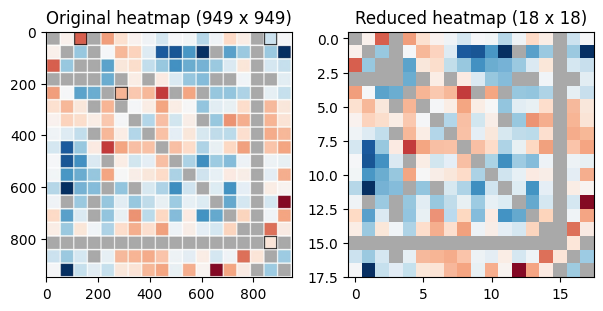

In [ ]:
# Define output variable
out['Van'] = dict()

# Define drug dictionary
abx = {'AMK': 'AMK', 
       'TEL': '', 
       'AZM': 'AZI', 
       'CLR': 'CLA', 
       'LZD': 'LIN', 
       'MXF': 'MOX', 
       'LXF': 'LEV', 
       'SPR': '', 
       'NFT': 'NIT', 
       'RIF': 'RIF', 
       'RFB': '', 
       'AMX': 'AMX', 
       'VAN': 'VAN', 
       'EMB': '', 
       'CER': 'CER', 
       'FOX': 'CEF', 
       'BDQ': '', 
       'TZ': 'THZ'
        }
out['Van']['abx'] = abx

# Read image (Figure 2A)
image = cv2.imread('./data/Van_2023_fig2a_hm.jpg', 1)

# Convert to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
out['Van']['original'] = image

# Get individual cells
n = len(abx.keys())
hm = np.empty((n, n, 3), dtype=int)
rm = np.empty((n, n), dtype=int)
gm = np.empty((n, n), dtype=int)
bm = np.empty((n, n), dtype=int)
zm = np.empty((n, n), dtype=float)
for i in range(0, n, 1): 
      for j in range(0, n, 1): 
        # Define image index
        x, y = 52*i+26, 52*j+26
        # Extract RGB value
        hm[i, j] = image[x, y]
        # Calculate score
        if all(hm[i, j]==[169, 169, 169]): 
            zm[i, j] = np.nan
        else: 
            zm[i, j] = ((hm[i, j, 0] - 255) - (hm[i, j, -1] - 255)) / hm[i, j, 1]
out['Van']['reduced'] = hm
out['Van']['scores'] = zm

# Sanity check #1
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3), constrained_layout=True)
ax[0].imshow(image)
ax[0].set_title('Original heatmap ({} x {})'.format(image.shape[0], image.shape[1]))
ax[1].imshow(hm)
ax[1].set_title('Reduced heatmap ({} x {})'.format(hm.shape[0], hm.shape[1]))

### 7.2 Inspect and process inferred scores

Absolute min: -1.9787234042553192
Absolute max: 10.555555555555555


Text(0.5, 1.0, 'Inferred score heatmap')

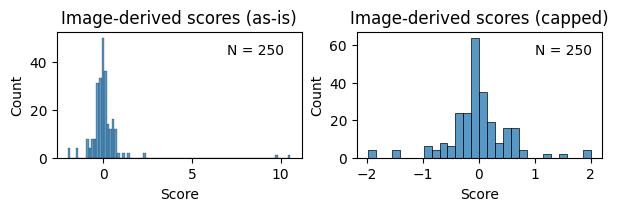

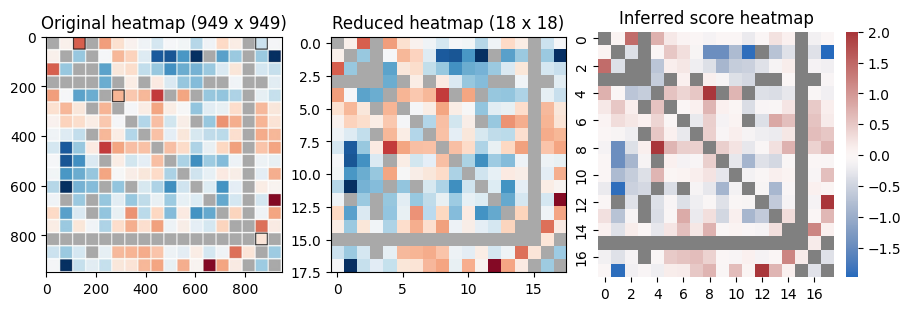

In [4]:
# Inspect min and max values
print('Absolute min: {}'.format(np.nanmin(zm)))
print('Absolute max: {}'.format(np.nanmax(zm)))

# Visualize score distribution (as-is)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 2), constrained_layout=True)
scores = out['Van']['scores'].reshape(-1)
sns.histplot(scores, ax=ax[0])
ax[0].set(xlabel='Score', ylabel='Count', title='Image-derived scores (as-is)')
ax[0].text(7, 43, 'N = {}'.format(sum(~np.isnan(scores))))

# Cap upper end
zm[zm > 2] = 2

# Visualize score distribution (capped)
scores = zm.reshape(-1)
sns.histplot(scores, ax=ax[1])
ax[1].set(xlabel='Score', ylabel='Count', title='Image-derived scores (capped)')
ax[1].text(1, 55, 'N = {}'.format(sum(~np.isnan(scores))))

# Sanity check #2
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9, 3), constrained_layout=True)
ax[0].imshow(image)
ax[0].set_title('Original heatmap ({} x {})'.format(image.shape[0], image.shape[1]))
ax[1].imshow(hm)
ax[1].set_title('Reduced heatmap ({} x {})'.format(hm.shape[0], hm.shape[1]))
nan_mask = np.isnan(zm)
cmap = sns.color_palette('vlag', as_cmap=True).copy()
cmap.set_bad('gray')
sns.heatmap(zm, center=0, cmap=cmap, mask=nan_mask, ax=ax[2])
ax[2].set_title('Inferred score heatmap')

### 7.3 Extract TACTIC predictions

Extract predictions for M. abscessus that match drugs evaluated in Van et al. study.

In [ ]:
# Define combinations
drugs = sorted(list(set(list(abx.values()))))[1:]
combos = []
for k in range(2, 3):
    combos.extend(combinations(drugs, k))
combos = [', '.join(i) for i in combos]

# Extract predictions
df = pd.DataFrame(index=combos)
df['Prediction'] = [out['landscape']['lb'].loc[i + ', LB', 'M. abscessus'] for i in combos]

### 7.4 Determine additional predictions

In [6]:
# Update drug dictionary to include BDQ, EMBx, and RIFP
new_drugs = ['BDQ', 'EMBx', 'RIFP']
abx.update({'BDQ': new_drugs[0], 'EMB': new_drugs[1], 'RFB': new_drugs[2]})

# Define interaction list
new_combos = []
for k in range(2, 3):
    new_combos.extend(combinations(sorted(drugs + new_drugs), k))
new_combos = [', '.join(i) for i in new_combos]
interactions = [i for i in new_combos if i not in combos]
ixn_list = [list(i.split(', ')) for i in interactions]
str_list = ['M. abscessus'] * len(ixn_list)

# Define new predictions
p1, p2  = ecoli['omics'].iloc[:, 1:].to_dict('list'), mtb['omics'].iloc[:, 1:].to_dict('list')
g1, g2  = ecoli['omics']['Gene'].tolist(), mtb['omics']['Gene'].tolist()
f1      = featurize(ixn_list, p1, feature_names=g1, key=ecoli['key'], strains=str_list, orthology_map=ecoli['map'])
f2      = featurize(ixn_list, p2, feature_names=g2, key=mtb['key'], strains=str_list, orthology_map=mtb['map'])
d1, d2  = f1['feature_df'].to_numpy().transpose(), f2['feature_df'].to_numpy().transpose()
x1      = np.zeros([d2.shape[0], d1.shape[1]], dtype=d2.dtype)
x1[np.array(f1['idx'])] = d1[np.array(f1['idx'])]
idx1    = [f in master['df'].index for f in list(f1['feature_df'].index)]
idx2    = [f in master['df'].index for f in list(f2['feature_df'].index)]
s1, s2  = sparse.csr_matrix(x1[:, np.array(idx1)]), sparse.csr_matrix(d2[:, np.array(idx2)])
X       = sparse.hstack((s1, s2))
mab_pred = out['model']['TACTIC'].predict(X)

# Add new predictions to prediction dataframe
df2 = pd.DataFrame({'Prediction': mab_pred}, index=interactions)
df = pd.concat([df, df2])

c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:337: UserWarning: Interaction entries do not match profile names, but key provided
  warn('Interaction entries do not match profile names, but key provided')
c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:351: UserWarning: Not all feature names are unique. Enforcing unique entries for output
  warn('Not all feature names are unique. Enforcing unique entries for output')
c:\Users\carol\AppData\Local\Programs\Python\Python310\lib\site-packages\indigopy\core.py:406: UserWarning: Drug profile information missing for 42 interactions
  warn('Drug profile information missing for {} interactions'.format(len(interactions) - len(ixn_list)))
Mapping orthologous genes: 100%|██████████| 1/1 [00:03<00:00,  3.46s/it]


### 7.5 Re-create heatmap based on predictions

Mimic Figure 2A based on TACTIC predictions.

Text(0.5, 1.0, 'TACTIC prediction heatmap')

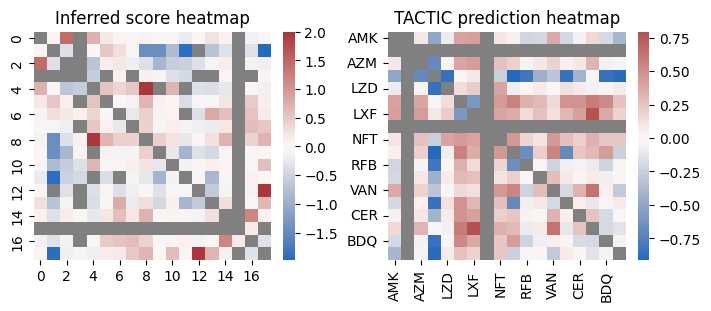

In [7]:
# Re-create heatmaps
phm = pd.DataFrame(np.nan, index=abx.keys(), columns=abx.keys())

for i in df.index: 
    # Extract individual drugs
    d1, d2 = i.split(', ')
    # Map to Figure 2A drug names
    row = list(abx.keys())[list(abx.values()).index(d1)]
    col = list(abx.keys())[list(abx.values()).index(d2)]
    # Populate dataframe
    phm.loc[row, col] = df.loc[i, 'Prediction']
    phm.loc[col, row] = df.loc[i, 'Prediction']
out['Van']['predictions'] = phm

# Visualize score vs. prediction heatmaps
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3), width_ratios=(1, 1), constrained_layout=True)
cmap = sns.color_palette('vlag', as_cmap=True).copy()
cmap.set_bad('gray')
nan_mask = np.isnan(zm)
sns.heatmap(zm, center=0, cmap=cmap, mask=nan_mask, ax=ax[0])
ax[0].set_title('Inferred score heatmap')
nan_mask = phm.isna()
sns.heatmap(phm, center=0, cmap=cmap, mask=nan_mask, ax=ax[1])
ax[1].set_title('TACTIC prediction heatmap')

### 7.6 Define dataframe of unique interactions

Create a dataframe including score + prediction for all unique interactions.

In [ ]:
# Convert score matrix to dataframe
zdf = pd.DataFrame(zm, index=abx.keys(), columns=abx.keys())

# Extract unique values
idx = np.triu_indices(zdf.shape[0], k=1)
ixns = zdf.index.values[idx[0]] + ', ' + zdf.columns.values[idx[1]]
scores, pred = zdf.values[idx], phm.values[idx]

# Define dataframe
pdf = pd.DataFrame({'Interaction': ixns, 'Score': scores, 'Prediction': pred})
pdf['Class'] = classify(pdf['Score'].tolist(), thresholds=(0, 0))
pdf.dropna(inplace=True)
print('Total number of unique interactions: {}'.format(pdf.shape[0]))
display(pdf.head())

# Save in out variable
out['Van']['table'] = pdf

Total number of unique interactions: 97


,Interaction,Score,Prediction,Class
1,"AMK, AZM",1.442105,0.098155,Antagonism
3,"AMK, LZD",0.740506,-0.094703,Antagonism
4,"AMK, MXF",0.195556,0.404542,Antagonism
5,"AMK, LXF",0.045643,0.427073,Antagonism
7,"AMK, NFT",-0.121212,0.107741,Synergy


In [20]:
# Checkpoint
with open('./TACTIC_data.pkl', 'wb') as f: 
    pickle.dump([ecoli, mtb, master, out], f)